# External Coefficient Forecasting with Bayesian Neural Networks

Author: **Adrian Tasistro-Hart**

# Introduction

This notebook will form the basis for a subsequent paper on probabilistic geomagnetic storm forecasting using neural networks. Previous works have focussed on forecasting the so-called disturbance storm time index (Dst), an index that is computed as the horizontal deviation in Earth's magnetic field relative to quiet times as measured by four low latitude stations. Dst thus measures the effect of geomagnetic storms on the dipole component of Earth's field, and storms themselves are defined in terms of a suppression of Earth's external field caused by an opposing magnetic field that is generated by a strengthened magnetospheric ring current. Ultimately, storms are driven by solar activity that is transmitted by the solar wind, but the exact physics, while roughly understood, are difficult to model on the scale of the magnetosphere given the sparsity of available measurements to provide boundary conditions and the computational cost of running plasma physics and magnetohydrodynamic simulations on that scale.

Thus, the space weather field has recognized the utility of learning algorithms that might be able to extract predictive information and physical structure from observations of the solar wind in order to make forecasts about the response of Earth's magnetic field to solar activity without having to run expensive and poorly-constrained physics-based forward models. 

The threat posed by geomagnetic storms lies in their geomagnetically induced currents (GICs) that can cripple power grids and communications infrastructure. These currents are induced by the net changes in the local magnetic field, which is composed of 1) the purely external forcings driven by the geomagnetic storms as well as 2) internally generated fields. These local interal fields are generated by sub-surface currents that are in turn generated by the time-varying external field. Thus, a knowledge of the external field forcings as well as Earth's subsurface conductivity structure allows for the straightforward computation of the induced interal fields and thus the total field.

## Limitations of Dst

UPDATE THIS

However, because Dst is computed as an average from four stations, each with different local conductivity structures (for example the Hermanus observatory in South Africa is right beside a highly conductive coast line), it does not capture the purely external field component and instead also includes the locally induced internal component. Thus, while Dst is sufficient for identifying geomagnetic storms, it does not provide the informtion about the purely external field that we ultimately need to be able to predict GICs, and a more sophisticated analysis is necessary to separate the locally induced and external field components. Furthermore, while much of the variation of Earth's magnetic field during geomagnetic storms occurs along the dipole component that is measured by Dst, significant variation also occurs with higher order spatial structure that cannot be captured by a single measurement. If we decompose Earth's external field into spherical harmonics (where Dst corresponds to the coefficient for the first zonal harmonic), then we also need to be able to forecast higher order coefficients in order to be able to faithfully describe the total response during geomagnetic storms. Then, if we are able to forecast these coefficients that describe purely the external field response to geomagnetic storms, then we can run forward simulations with Earth conductivity structures to capture local field variations and whether they could potentially generate GICs.


## Limitations of previous NN forecasts

Of previous studies that forecast Dst via neural networks, the major limitation has been incorporating measures of uncertainty into the forecasts. The construction of regressional neural networks is conducive to thinking in deterministic terms, since neural networks amount to functions that explicitly map inputs to outputs. Only one study to my knowledge attempts to include a measure of uncertainty (Gruet et al 2018). They are also the first to produce Dst forecasts with the long short-term memory (LSTM) recurrent neural network, whose outputs they take as "mean" values that center an independently parameterized Gaussian process model, which in turn provides the uncertainties. However, this approach struggles to generate useful uncertainty measures for multiple hour-ahead forecasts, especially for 5 and 6 hour ahead forecasts of a storm main phase (see figure). 

<img src='figures/conf_int.jpg' width=500px />

Intuitively, this makes sense, because solar wind data collected from satellites at the L1 point about one hour upstream of the magnetosphere should not have predictive information about storm main phase arrival more than a couple hours in advance. Thus, estimated means for multiple hour ahead forecasts will substantially underestimate the true magnitude, but Gaussian process uncertainty estimation is unable to account for this discrepancy. This follows from the nature of Gaussian processes: they are completely described by a mean function and a covariance model. The covariance model implemented by Gruet et al utilizes variation in the 6 hour history of Dst at different points in time as the basis for modeling covariance. This covariance function thus gives low covariance measures for points whose 6 hour Dst histories are dissimilar (minimal if they are orthogonal in the space ${\rm I\!R}^6$), but the 6 hour histories for the forecasted points are constructed entirely from the neural network output, which is unable to predict storm arrivals. Thus, the covariance function itself cannot detect storm arrivals and cannot even model the uncertainty in forecasts that might involve storm arrivals because the model covariances are derived from forecasts themselves.

### Variational Bayesian neural networks

We therefore need a different approach to modeling uncertainty in multiple hour ahead forecasts, and the field of variational Bayesian neural networks holds great promise. These networks learn epistemic uncertainty, or uncertainty in the model, and thus could learn to model their own inability to predict storm main phases in t+6 forecasts. 

In variational Bayesian neural networks, epistemic uncertainty is encoded by modeling distributions over the neural network weights. In this way, models are sampled by sampling weights from their distributions, and uncertainty in the model should be captured by uncertainty in the weights. In the ideal world, we are then trying to model $p(\mathbf{w} \vert \mathbf{x}, \mathbf{y})$, which is a posterior distribution over the network weights given the observed data. While we could sample from this distribution using techniques like MCMC, in general we cannot learn this probability density for all network weights in reasonable time. Instead, the goal is to learn a variational posterior $q(\mathbf{w} \vert \theta)$, parameterized by $\theta$, which has a much simpler form than the unknown true posterior. Since we seek a variational posterior that is as similar as possible to the true posterior, we need to define a metric of misfit between the distributions. The Kullback-Leibler divergence is a commonly chosen measure, and we thus have the following optimization problem:

$$\underset{\theta}{\text{min}} \; D_{KL}( q(\mathbf{w} \vert \theta) \Vert p(\mathbf{w} \vert \mathbf{x}, \mathbf{y})) = \underset{\theta}{\text{min}} \; \int_\mathbf{w} q(\mathbf{w} \vert \theta)\,\log\frac{q(\mathbf{w} \vert \theta)}{p(\mathbf{w} \vert \mathbf{x}, \mathbf{y})}\,d\mathbf{w}$$

Furthermore, since we do not have access to the true posterior, we represent it via Bayes' theorem $p(\mathbf{w} \vert \mathbf{x}, \mathbf{y}) = \frac{p(\mathbf{x}, \mathbf{y} \vert \mathbf{w})\, p(\mathbf{w})}{p(\mathbf{x}, \mathbf{y})} $, and the minimization becomes:

$$ \underset{\theta}{\text{min}} \; \int_\mathbf{w} q(\mathbf{w} \vert \theta)\,\log\frac{q(\mathbf{w} \vert \theta)\, p(\mathbf{x}, \mathbf{y})}{p(\mathbf{x}, \mathbf{y} \vert \mathbf{w})\, p(\mathbf{w})}\,d\mathbf{w} =  $$

$$ \underset{\theta}{\text{min}} \; \int_\mathbf{w} q(\mathbf{w} \vert \theta)\,\log q(\mathbf{w} \vert \theta) \, d\mathbf{w} + \int_\mathbf{w} q(\mathbf{w}\vert\theta) \,\log{p(\mathbf{x}, \mathbf{y})} \, d\mathbf{w} - \int_\mathbf{w} q(\mathbf{w} \vert \theta)\,p(\mathbf{w}) \, d\mathbf{w} - \int_\mathbf{w} q(\mathbf{w} \vert \theta)\, p(\mathbf{x}, \mathbf{y} \vert \mathbf{w}) \, d\mathbf{w} =  $$

$$
\underset{\theta}{\text{min}} \; \mathbb{E}_q \left[ \log q(\mathbf{w} \vert \theta)\right] - \mathbb{E}_q \left[ \log p(\mathbf{w}) \right] - \mathbb{E}_q \left[ \log p(\mathbf{x}, \mathbf{y} \vert \mathbf{w})\right]
$$

where we ignore the $\int_\mathbf{w} q(\mathbf{w}\vert\theta) \,\log{p(\mathbf{x}, \mathbf{y})} \, d\mathbf{w}$ term because it does not depend on $\theta$. Our final expression then depends only on the variational posterior, a prior over the weights (which we must specify), and a likelihood term dependent on the data. This likelihood term is captured by the neural network itself. Because the expectations are taken over the variational posterior, we can approximate them simply by sampling weights from their variational posteriors for given $\theta$, and then we can update $\theta$ by differentiating this loss against $\theta$.

Given that the differentiation can easily be done by new deep learning frameworks like Tensorflow, what remains is only to add the so-called "KL-losses" $ \mathbb{E}_q \left[ \log q(\mathbf{w} \vert \theta)\right] - \mathbb{E}_q \left[ \log p(\mathbf{w}) \right]$ to the negative log-likelihood loss of the data given weights sampled from the variational posterior while ensuring that the learnable parameters in the network are the $\theta$ parameterizing the variational posterior distributions over the weights.

The above derivations are explained in greater detail by Blundell et al. (2015), and, for recurrent neural networks, by Fortunato et al. (2018). I have implemented the algorithm of Fortunato et al. (2018) in [bdl_tensorflow.py](bdl_tensorflow.py), but without their so-called posterior sharpening.

## Probabilistic output

finish this

$$ p(y_{t+k} \vert y_{t}, x_{t}, c_{t}) $$

# Load Data

Now let's load all the datasets. After loading, combine all of the data into a single dataframe.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import numpy as np
from sklearn import preprocessing
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize'] = [8, 8]

import pandas as pd
from tqdm import tqdm_notebook

from bdl_tensorflow import *
from helper_functions import *
import itertools

In [16]:
omni = pd.read_hdf('data/omni_hourly_alldata_smallfilled.h5')
goes = pd.read_hdf('data/GOES_xrs_xhf_hourly_1986-2018.h5')
ext = pd.read_hdf('data/external_coefficients.h5')
cme = pd.read_hdf('data/cme_hourly_complete.h5')
p10s = pd.read_hdf('data/dst_est_ist.h5')

dst = omni['Dst (nT)']

# let's use the most relevant SW measurements from omni
omni_use_cols = ['BX, nT (GSE, GSM)',
                'BY, nT (GSM)',
                'BZ, nT (GSM)',  
                'SW Proton Density, N/cm^3',  
                'SW Plasma Speed, km/s',  
                'SW Plasma Temperature, K',
                'SW Plasma flow long. angle',
                'SW Plasma flow lat. angle',]

# use all GOES data
goes_use_cols = ['short channel',
                'long channel']

# cme data to use
cme_use_cols = ['Central PA', 
                'Width',
                'Linear Speed',
                '2nd order speed: initial',
                 '2nd order speed: final',
                 '2nd order speed: 20R',
                 'Accel',
                'Mass',
                'Kinetic energy']

# p10 terms to use, just est for now
p10s_use_cols = ['est']

# let's focus on first zonal coefficients
ext_use_cols = ['q10']

# form full dataframe
data = pd.concat([omni[omni_use_cols], goes[goes_use_cols], p10s[p10s_use_cols], cme[cme_use_cols]], axis=1)

Having loaded the datasets, now formulate input and output.

In [17]:
in_cols = list(itertools.chain(goes_use_cols, cme_use_cols, omni_use_cols, p10s_use_cols))
# in_cols = goes_use_cols

out_cols = p10s_use_cols

data_in = data[in_cols].copy()
data_out = data[out_cols].copy()

input_dim = data_in.shape[1]
output_dim = data_out.shape[1]

ndat = data.shape[0]
t = data.index

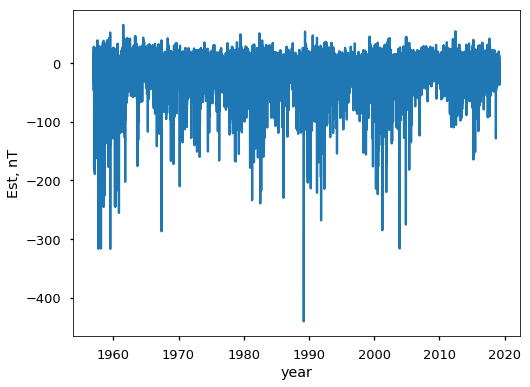

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(data_out)
ax.set_ylabel('Est, nT')
ax.set_xlabel('year')
plt.show()

Let's do a bit of preprocessing on the data with orders of magnitude of variation. Mostly, we'll want to use a logarithm of the data. Such data are:
- x-ray flux short and long channels
- CME mass and kinetic energies

In [19]:
# only run if using CME or x-ray data
data_in['short channel'] = np.log10(data_in['short channel']+1e-8)
data_in['long channel'] = np.log10(data_in['long channel']+1e-8)
data_in['Mass'] = np.log10(data_in['Mass'] + 1e13)
data_in['Kinetic energy'] = np.log10(data_in['Kinetic energy'] + 1e27)

## Split data

Here split the data into training and testing sets. We'll use the Sampler class in the helper_functions file. Don't forget that for the LSTM, the input data needs to be rank 3, with the input dimensionality along the last dimension. The outputs should be rank 2.

In [20]:
lahead = 6
train_percent = 0.9
test_percent = 0.1
val_percent = 0.0
batch_size = 1000

In [21]:
data_in_arr = data_in[0:-lahead].values.astype(np.float32)
data_out_arr = data_out[lahead:].values.astype(np.float32)

t_in = t[0:-lahead]
t_out = t[lahead:]

dataset = Dataset(data_in_arr, data_out_arr)

data_in_train, \
data_out_train, \
data_in_test, \
data_out_test, \
data_in_val, \
data_out_val, \
t_train, \
t_test,\
t_val = dataset.split(batch_size,                                                                                               
                          train_frac=train_percent,                                                         
                          test_frac=test_percent,                                                                                         
                          ext_array=np.concatenate([t_in.values.reshape(-1,1),
                                                    t_out.values.reshape(-1,1)], axis=1))

t_in_train = t_train[:,0]
t_out_train = t_train[:,1]
t_in_test = t_test[:,0]
t_out_test = t_test[:,1]

## Normalize

Let's train a normalizer from the training data and apply it to both the training and testing datasets.

In [22]:
# normalize
scaler_input = preprocessing.MinMaxScaler(feature_range=(0,1))
data_in_train_scaled = scaler_input.fit_transform(data_in_train)
data_in_test_scaled = scaler_input.transform(data_in_test)
data_in_arr_scaled = scaler_input.transform(data_in_arr)

# scaler_output = preprocessing.MinMaxScaler(feature_range=(0,1))
# data_out_train = scaler_output.fit_transform(data_out_train)
# data_out_test = scaler_output.transform(data_out_test)

# reshape input data
data_in_train_scaled = data_in_train_scaled.reshape(-1, 1, input_dim)
data_in_test_scaled = data_in_test_scaled.reshape(-1, 1, input_dim)
data_in_arr_scaled = data_in_arr_scaled.reshape(-1, 1, input_dim)

Visualize the scaled data to make sure nothings fucky.

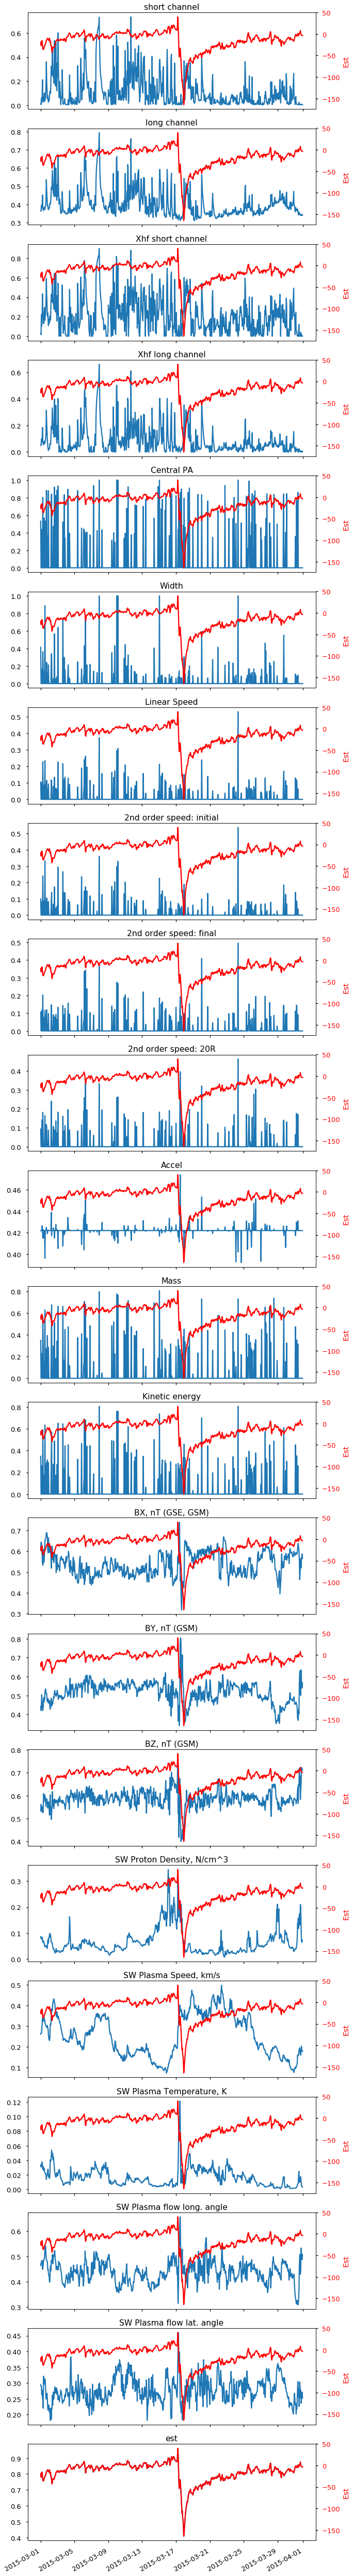

In [12]:
idx_in = (t_in.year == 2015) & (t_in.month == 3)
idx_out = (t_out.year == 2015) & (t_out.month == 3)

# plot inputs with q10 superimposed
fig, axs = plt.subplots(input_dim, 1, figsize=(10, 100))
for ii, ax in enumerate(axs):
    ax.plot(t_in[idx_in], data_in_arr_scaled[idx_in, 0, ii])
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('Est', color='r')  # we already handled the x-label with ax1
    ax2.plot(t_out[idx_out], data_out_arr[idx_out], color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    ax.set_title(in_cols[ii])

fig.autofmt_xdate()
plt.show()


# Probabilistic model, deterministic output

Here I perform Bayes-by-Backprop with deterministic output, meaning that only the model weights are modeled probabilistically as discussed above.

## Train and test

Now let's create, train, and test the variational Bayesian recurrent neural network.

## Design network

In [169]:
n_batch = data_in_train.shape[0]/batch_size
kl_weight =  1/n_batch

units_1 = 20
units_2 = 10
units_3 = 5

In [170]:
dense_prior_sig1 = 1.0
dense_prior_sig2 = 0.1
dense_prior_pi = 0.2

lstm_prior_sig1 = 1.0
lstm_prior_sig2 = 0.1
lstm_prior_pi = 0.2

lstm_prior_1 = Prior(lstm_prior_sig1, lstm_prior_sig2, lstm_prior_pi, name='lstm_prior_1')
lstm_prior_2 = Prior(lstm_prior_sig1, lstm_prior_sig2, lstm_prior_pi, name='lstm_prior_2')
lstm_prior_3 = Prior(lstm_prior_sig1, lstm_prior_sig2, lstm_prior_pi, name='lstm_prior_3')
dense_prior_1 = Prior(dense_prior_sig1, dense_prior_sig2, dense_prior_pi, name='dense_prior_1')
dense_prior_2 = Prior(dense_prior_sig1, dense_prior_sig2, dense_prior_pi, name='dense_prior_2')

In [173]:
x_in = tf.keras.layers.Input(shape=(1, input_dim, ))
x = LSTMVariational(units_1, lstm_prior_1, kl_weight, prior_trainable=True, return_sequences=False)(x_in)
# x = LSTMVariational(units_2, lstm_prior_2, kl_weight, prior_trainable=False, 
#                     return_sequences=True)(x)
# x = LSTMVariational(units_3, lstm_prior_3, kl_weight, prior_trainable=False, 
#                     return_sequences=False)(x)
#x = DenseVariational(10, dense_prior_1, kl_weight, prior_trainable=False, activation='relu')(x)
x = DenseVariational(output_dim, dense_prior_2, kl_weight, prior_trainable=True, activation=None)(x)
#x = tf.keras.layers.Dense(output_dim)(x)
model = tf.keras.models.Model(x_in, x)

In [174]:
def neg_log_likelihood(y_true, y_pred, sigma=5):
    dist = tfd.Normal(loc=y_true, scale=sigma)
    return K.sum(-dist.log_prob(y_pred))

In [175]:
model.compile(loss=neg_log_likelihood, \
              optimizer=tf.keras.optimizers.Adam(lr=0.002), \
              metrics=['mse'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 20)]           0         
_________________________________________________________________
lstm_variational_1 (LSTMVari (None, 20)                6563      
_________________________________________________________________
dense_variational_1 (DenseVa (None, 1)                 45        
Total params: 6,608
Trainable params: 6,608
Non-trainable params: 0
_________________________________________________________________


## Train network

In [184]:
model.fit(data_in_train_scaled,
          data_out_train,
          epochs=200,
          verbose=0,
          shuffle=False,
          batch_size=batch_size,
          callbacks=[PeriodicHistory()])

Epoch 0: Loss = 3787.10, MSE = 6.20e+01
Epoch 10: Loss = 3784.68, MSE = 6.19e+01
Epoch 20: Loss = 3785.05, MSE = 6.19e+01
Epoch 30: Loss = 3775.03, MSE = 6.14e+01
Epoch 40: Loss = 3777.05, MSE = 6.15e+01
Epoch 50: Loss = 3778.96, MSE = 6.16e+01
Epoch 60: Loss = 3778.13, MSE = 6.16e+01
Epoch 70: Loss = 3771.89, MSE = 6.13e+01
Epoch 80: Loss = 3775.02, MSE = 6.14e+01
Epoch 90: Loss = 3772.35, MSE = 6.13e+01
Epoch 100: Loss = 3768.63, MSE = 6.11e+01
Epoch 110: Loss = 3769.26, MSE = 6.11e+01
Epoch 120: Loss = 3777.84, MSE = 6.16e+01
Epoch 130: Loss = 3767.86, MSE = 6.10e+01
Epoch 140: Loss = 3763.62, MSE = 6.08e+01
Epoch 150: Loss = 3766.12, MSE = 6.10e+01
Epoch 160: Loss = 3764.26, MSE = 6.09e+01
Epoch 170: Loss = 3763.50, MSE = 6.08e+01
Epoch 180: Loss = 3758.85, MSE = 6.06e+01
Epoch 190: Loss = 3759.53, MSE = 6.06e+01


## Test network

In [191]:
data_out_pred_list = []
import tqdm
for ii in tqdm.tqdm(range(5000)):
    cur_pred = model.predict(data_in_test_scaled, batch_size=batch_size)
    data_out_pred_list.append(cur_pred)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:45<00:00, 47.35it/s]


In [194]:
data_out_preds = np.concatenate(data_out_pred_list, axis=1)
data_out_pred_mu = np.mean(data_out_preds, axis=1).reshape(-1,1)
data_out_pred_std = np.std(data_out_preds, axis=1).reshape(-1,1)
conf_int = np.percentile(data_out_preds, [0.1, 99.9], axis=1).T

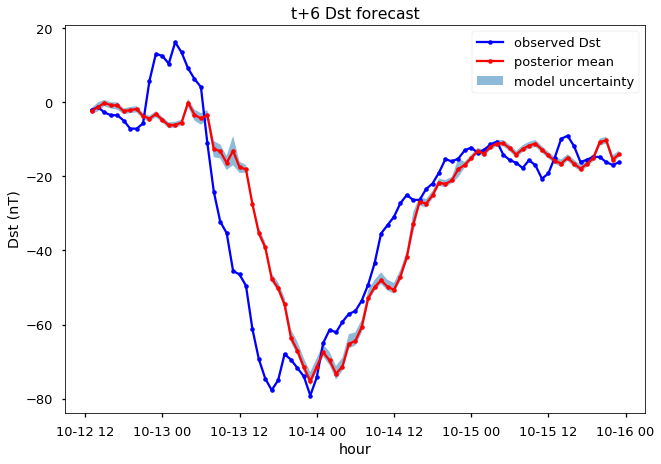

In [195]:
# storm 1
idx = (t_out_test > np.datetime64('2016-10-12T12:00')) & \
        (t_out_test < np.datetime64('2016-10-16T00:00')) 

# storm 4
# idx = (t_out_test > np.datetime64('2015-03-15T12:00')) & \
#         (t_out_test < np.datetime64('2015-03-22T00:00'))

# storm 5
# idx = (t_out_test > np.datetime64('2015-07-09T12:00')) & \
#         (t_out_test < np.datetime64('2015-07-17T00:00'))

full_fmt = mdates.DateFormatter('%y-%b-%d %H:%M')
yr_mon_dd_fmt = mdates.DateFormatter('%y-%b-%d')
hour_tick = mdates.HourLocator()

plt.figure()
plt.plot(t_out_test[idx], data_out_test[idx], 'b.-', label='observed Dst')
plt.plot(t_out_test[idx], data_out_pred_mu[idx], 'r.-', label='posterior mean')
plt.fill_between(t_out_test[idx],
                conf_int[idx,0],
                conf_int[idx,1],
                label='model uncertainty',
                alpha=0.5)
plt.legend(loc='lower right')
plt.xlabel('date')
ax = plt.gca()
ax.xaxis.set_major_formatter(full_fmt)
ax.xaxis.set_minor_locator(hour_tick)
plt.ylabel('Est (nT)')
ax.set_title('t+%d Est forecast, SW + CME + X-ray, 95%% exceedance = %1.2f%%' % (lahead, exc))
plt.grid()
fig.autofmt_xdate()
#plt.savefig('figures/Est_forecast_SWCMEXrayt+6_storm1.pdf')
plt.show()


## Discuss

Surprisingly, the level of epistemic uncertainty is very low, meaning that the trained networks are quite confident in the ultimate model, even though this model performs poorly for Dst forecasting. This result was discouraging initially, but in retrospect it makes a lot of sense: Epistemic uncertainty should not be able to effectively model a distribution over possible outputs, it should just attempt to capture uncertainty in models that are able to predict outputs reasonably close to observations. For a six hour ahead forecast of geomagnetic storms from L1 data, however, there is simply no information about the main phase of a storm, but yet this does not mean that a large range of models are actually feasible given the time history of inputs and the given loss function. In fact, the network is confident that the family of models is quite well constrained, and for the recovery phase of storms, the epistemic uncertainty does in fact straddle the observed data quite well. This makes sense, since the structure of the recovery phase (which is approximately exponential decay) is easier to predict in advance, and the model uncertainty is more relevant for a part of the process that the network can actually learn something about. 

Thus, what we really need is the ability to learn a distribution over reasonable outputs given a time history of inputs. At each point then, the network learns to predict a mean and variance for the t+n hour ahead forecast. For a six hour ahead forecast, I anticipate that once a storm begins, forecasted uncertainties should grow substantially and then decrease as the storm enters the recovery phase, which is more predictable. Ideally, this distribution would be asymmetric, since during storm main phases, the network tends to overestimate Dst (i.e. main phases are more severe than the network predicts), so there should be higher uncertainty towards more negative Dst values. I can think about implemnting a skew normal distribution in tensorflow.

# Probabilistic model, probabilistic output

Here, I both treat network weights and network outputs probabilistically.

## Design network

In [153]:
n_batch = data_in_train.shape[0]/batch_size
kl_weight = 1/n_batch

lstm_dim_1 = 10
lstm_dim_2 = 10

dense_dim_1 = 10
dense_dim_1 = 10

In [154]:
dense_prior_sig1 = 1.0
dense_prior_sig2 = 0.1
dense_prior_pi = 0.2

lstm_prior_sig1 = 1.0
lstm_prior_sig2 = 0.1
lstm_prior_pi = 0.2

lstm_prior_1 = Prior(lstm_prior_sig1, lstm_prior_sig2, lstm_prior_pi, name='lstm_prior_1')
lstm_prior_2 = Prior(lstm_prior_sig1, lstm_prior_sig2, lstm_prior_pi, name='lstm_prior_2')
dense_prior_1 = Prior(dense_prior_sig1, dense_prior_sig2, dense_prior_pi, name='dense_prior_1')
dense_prior_2 = Prior(dense_prior_sig1, dense_prior_sig2, dense_prior_pi, name='dense_prior_2')

In [155]:
x_in = tf.keras.layers.Input(shape=(1, input_dim, ))
x = LSTMVariational(lstm_dim_1, lstm_prior_1, kl_weight, prior_trainable=True, return_sequences=False)(x_in)
# x = DenseVariational(2, dense_prior_2, kl_weight, prior_trainable=True, activation=None)(x)
x = tf.keras.layers.Dense(dense_dim_1, activation='tanh')(x)
x = tf.keras.layers.Dense(2, 
                      kernel_initializer=tf.keras.initializers.Constant(0), 
                      bias_initializer=tf.keras.initializers.Constant([0, 20]))(x)
x = tfp.layers.DistributionLambda(lambda t: tfd.Gumbel(loc=t[..., 0:1], 
                                scale=1e-3 + tf.math.softplus(1.0 * t[...,1:])))(x)
model = tf.keras.models.Model(x_in, x)

In [37]:
def neg_log_likelihood(y_true, y_pred, sigma=0.2):
    dist = tfd.Normal(loc=y_true, scale=sigma)
    return K.sum(-dist.log_prob(y_pred))

In [156]:
negloglik = lambda y, p_y: -p_y.log_prob(y)

In [157]:
model.compile(loss=negloglik, \
              optimizer=tf.keras.optimizers.Nadam(lr=0.002), \
              metrics=['mse'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1, 6)]            0         
_________________________________________________________________
lstm_variational_4 (LSTMVari (None, 10)                1363      
_________________________________________________________________
dense_78 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_79 (Dense)             (None, 2)                 22        
_________________________________________________________________
distribution_lambda_25 (Dist ((None, None), (None, Non 0         
Total params: 1,495
Trainable params: 1,495
Non-trainable params: 0
_________________________________________________________________


## Train

In [160]:
model.fit(data_in_train_scaled,
          data_out_train,
          epochs=500,
          verbose=0,
          shuffle=False,
          batch_size=batch_size,
          callbacks=[PeriodicHistory()])

Epoch 0: Loss = 6.24, MSE = 1.05e+03
Epoch 10: Loss = 4.07, MSE = 5.28e+02
Epoch 20: Loss = 4.07, MSE = 5.30e+02
Epoch 30: Loss = 4.07, MSE = 5.32e+02
Epoch 40: Loss = 4.07, MSE = 5.33e+02
Epoch 50: Loss = 4.07, MSE = 5.31e+02
Epoch 60: Loss = 4.07, MSE = 5.30e+02
Epoch 70: Loss = 4.07, MSE = 5.33e+02
Epoch 80: Loss = 4.07, MSE = 5.32e+02
Epoch 90: Loss = 4.07, MSE = 5.33e+02
Epoch 100: Loss = 4.07, MSE = 5.36e+02
Epoch 110: Loss = 4.07, MSE = 5.33e+02
Epoch 120: Loss = 4.07, MSE = 5.36e+02
Epoch 130: Loss = 4.07, MSE = 5.33e+02
Epoch 140: Loss = 4.07, MSE = 5.34e+02
Epoch 150: Loss = 4.07, MSE = 5.33e+02
Epoch 160: Loss = 4.07, MSE = 5.35e+02
Epoch 170: Loss = 4.07, MSE = 5.31e+02
Epoch 180: Loss = 4.07, MSE = 5.30e+02
Epoch 190: Loss = 4.07, MSE = 5.31e+02
Epoch 200: Loss = 4.07, MSE = 5.31e+02
Epoch 210: Loss = 4.07, MSE = 5.32e+02
Epoch 220: Loss = 4.07, MSE = 5.28e+02
Epoch 230: Loss = 4.07, MSE = 5.29e+02
Epoch 240: Loss = 4.07, MSE = 5.39e+02
Epoch 250: Loss = 4.07, MSE = 5.34e+

## Test

In [46]:
data_out_pred_locs = []
data_out_pred_scales = []
import tqdm
for ii in tqdm.tqdm(range(100)):
    cur_model = model(data_in_test)
    data_out_pred_locs.append(cur_model.loc)
    data_out_pred_scales.append(cur_model.scale)
    
data_out_pred_locs = np.concatenate(data_out_pred_locs, axis=1)
data_out_pred_scales = np.concatenate(data_out_pred_scales, axis=1)

100%|██████████| 100/100 [00:04<00:00, 20.97it/s]


In [47]:
data_out_pred_loc = np.mean(data_out_pred_locs, axis=1)
data_out_pred_scale = np.mean(data_out_pred_scales, axis=1)

# UPDATE THIS 
err = np.abs(data_out_pred_mean - data_out_test[:,0])

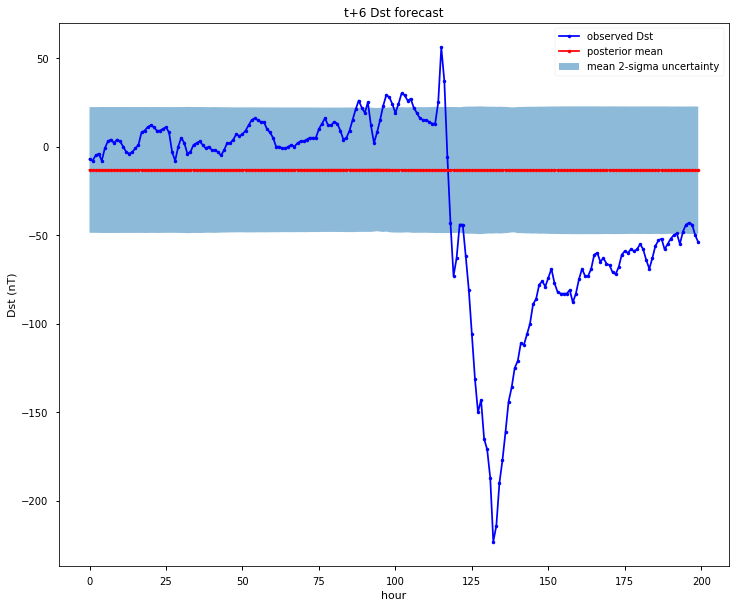

In [48]:
idx = np.zeros(data_out_test.shape[0], dtype=bool)
idx[4700:4900] = True

fac = 2

plt.figure(figsize=(12,10))
plt.plot(data_out_test[idx], 'b.-', label='observed Dst')
plt.plot(data_out_pred_mean[idx], 'r.-', label='posterior mean')
plt.fill_between(np.arange(np.sum(idx)),
                data_out_pred_mean[idx] + fac*data_out_pred_std[idx],
                data_out_pred_mean[idx] - fac*data_out_pred_std[idx],
                label='mean 2-sigma uncertainty',
                alpha=0.5)
plt.legend()
plt.xlabel('hour')
plt.ylabel('Dst (nT)')
plt.title('t+6 Dst forecast')
#plt.savefig('figures/demo1.pdf')
plt.show()


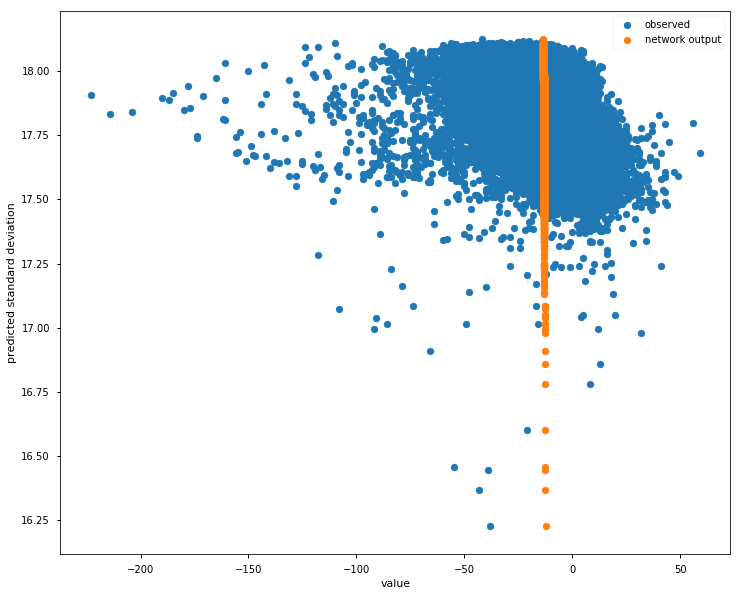

In [50]:
plt.figure(figsize=(12,10))
plt.scatter(data_out_test, data_out_pred_std, label='observed')
plt.scatter(data_out_pred_mean, data_out_pred_std, label='network output')
plt.xlabel('value')
plt.ylabel('predicted standard deviation')
plt.legend()
plt.show()

# Deterministic model, probabilistic output

Here I assume that the model weights are fully fixed and deterministic, and the network learns the parameters for an output distribution (currently Gaussian). 

In [692]:
lstm_dim_1 = 20
lstm_dim_2 = 10
lstm_dim_3 = 5
lstm_dim_4 = 10

dense_dim_1 = 5
dense_dim_2 = 10
dense_dim_3 = 5
dense_dim_4 = 5

In [693]:
model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(dense_dim_1, 
#                           activation='tanh'),
    tf.keras.layers.LSTM(lstm_dim_1, return_sequences=True, input_shape=(1, input_dim)),
    tf.keras.layers.LSTM(lstm_dim_2, return_sequences=False),
#     tf.keras.layers.LSTM(lstm_dim_3, return_sequences=False),
#     tf.keras.layers.LSTM(lstm_dim_4, return_sequences=False),
    tf.keras.layers.Dense(dense_dim_2, 
                          activation='tanh'),
#     tf.keras.layers.Dense(dense_dim_3, 
#                           activation='tanh'),
    tf.keras.layers.Dense(2, 
                          kernel_initializer=tf.keras.initializers.Constant(0), 
                          bias_initializer=tf.keras.initializers.Constant([0, 20])),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Gumbel(loc=t[..., 0:1], 
                             scale=1e-3 + tf.math.softplus(1.0 * t[..., 1:])))
])

In [23]:
model_name = 'Estout_XrayCMESWEst_Gumbel_L20L10D10_t6'
model_save_path = 'models/' + model_name + '/model.h5'
model_weights_path = 'models/' + model_name + '/cp.ckpt'

In [11]:
def negloglik(y, p_y):
    return -p_y.log_prob(y)

In [696]:
model.compile(loss=negloglik, 
              optimizer=tf.keras.optimizers.Adam(lr=0.002), 
              metrics=['mse'])

In [697]:
model.save(model_save_path)

## Train

While training, we will also save model weights periodically (every 10 epochs), keeping only those that actually improve on the loss function.

In [698]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_weights_path,
    verbose=1, 
    save_weights_only=True,
    period=100)

In [ ]:
# minus sign on data_out_train so that we use Gumbel left skewed, not right
model.fit(data_in_train_scaled,
          -data_out_train,
          epochs=3000,
          verbose=0,
          shuffle=False,
          batch_size=batch_size,
          callbacks=[PeriodicHistory(), cp_callback])

## Test

Load existing model if already trained.

In [24]:
# load existing model weights
model = tf.keras.models.load_model(model_save_path, custom_objects={'negloglik':negloglik})
model.load_weights(model_weights_path)

Create vector of distributions representing output at each test location.

In [164]:
post_model_test = model(data_in_test_scaled)

# minus sign for reverse skewness of Gumbel
data_out_pred_test_loc = -post_model_test.loc.numpy()
data_out_pred_test_scale = post_model_test.scale.numpy()
# make distributions from learned parameters
data_out_pred_test = [stats.gumbel_l(loc=loc, scale=scale) for loc, scale in zip(data_out_pred_test_loc, data_out_pred_test_scale)]

Do the same for the training data.

In [165]:
post_model_train = model(data_in_train_scaled)

# minus sign for reverse skewness of Gumbel
data_out_pred_train_loc = -post_model_train.loc.numpy()
data_out_pred_train_scale = post_model_train.scale.numpy()
# make distributions from learned parameters
data_out_pred_train = [stats.gumbel_l(loc=loc, scale=scale) for loc, scale in zip(data_out_pred_train_loc, data_out_pred_train_scale)]

Do for all input data.

In [25]:
post_model = model(data_in_arr_scaled)

# minus sign for reverse skewness of Gumbel
data_out_pred_loc = -post_model.loc.numpy()
data_out_pred_scale = post_model.scale.numpy()
# make distributions from learned parameters
data_out_pred = [stats.gumbel_l(loc=loc, scale=scale) for loc, scale in zip(data_out_pred_loc, data_out_pred_scale)]

In [92]:
err = np.abs(data_out_pred_loc - data_out_arr)

lb = [dist.ppf(0.025) for dist in data_out_pred]
ub = [dist.ppf(0.975) for dist in data_out_pred]
conf_int = np.concatenate((lb, ub), axis=1)

exc = np.concatenate((data_out_arr > ub, data_out_arr < lb), axis=1)
exc = 100 * np.sum(np.any(exc, axis=1))/data_out_arr.shape[0]

C:\anaconda\envs\tf2\lib\site-packages\scipy\stats\_distn_infrastructure.py:1913: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
C:\anaconda\envs\tf2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
C:\anaconda\envs\tf2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


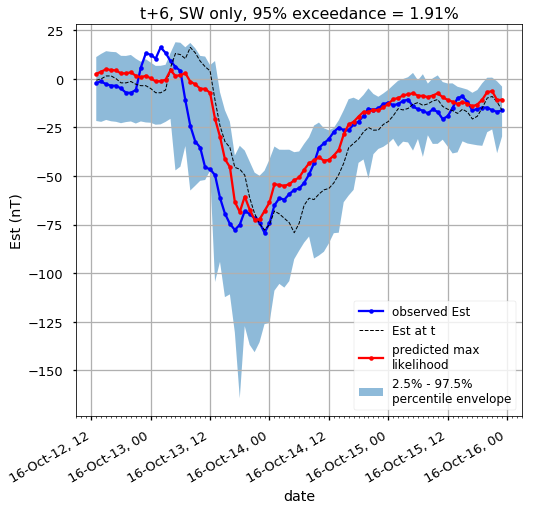

In [99]:
# storm 1
idx = (t_out > np.datetime64('2016-10-12T12:00')) & \
        (t_out  < np.datetime64('2016-10-16T00:00')) 

# storm 2
# idx = (t_out > np.datetime64('2017-05-27T00:00')) & \
#         (t_out < np.datetime64('2017-05-31T00:00')) 

# storm 3
# idx = (t_out_test > np.datetime64('2017-09-06T12:00')) & \
#         (t_out_test < np.datetime64('2017-09-11T00:00'))

# storm 4
# idx = (t_out > np.datetime64('2015-03-15T12:00')) & \
#         (t_out < np.datetime64('2015-03-22T00:00'))

# storm 5
# idx = (t_out > np.datetime64('2015-07-09T12:00')) & \
#         (t_out < np.datetime64('2015-07-17T00:00'))

full_fmt = mdates.DateFormatter('%y-%b-%d, %H')
yr_mon_dd_fmt = mdates.DateFormatter('%y-%b-%d')
hour_tick = mdates.HourLocator()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t_out[idx], data_out_arr[idx], 'b.-', label='observed Est')
ax.plot(t_out[idx], data_in_arr[idx, -1], 'k--', label='Est at t', linewidth=1.0)
ax.plot(t_out[idx], data_out_pred_loc[idx], 'r.-', label='predicted max\nlikelihood')
ax.fill_between(t_out[idx],
                conf_int[idx, 0],
                conf_int[idx, 1],
                label='2.5% - 97.5% \npercentile envelope',
                alpha=0.5)

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
# ax2.set_ylabel('data in', color='g')  # we already handled the x-label with ax1
# ax2.plot(data_in_test_scaled[idx, 0, 0].squeeze())
# ax2.tick_params(axis='y', labelcolor='g')

ax.legend(loc='lower right', fontsize='large')
ax.set_xlabel('date')
ax.xaxis.set_major_formatter(full_fmt)
ax.xaxis.set_minor_locator(hour_tick)
ax.set_ylabel('Est (nT)')
ax.set_title('t+%d, SW only, 95%% exceedance = %1.2f%%' % (lahead, exc))
plt.grid()
fig.autofmt_xdate()
plt.savefig('figures/est_forecast_SW_Gumbel_t+6_storm1.pdf')
plt.show()

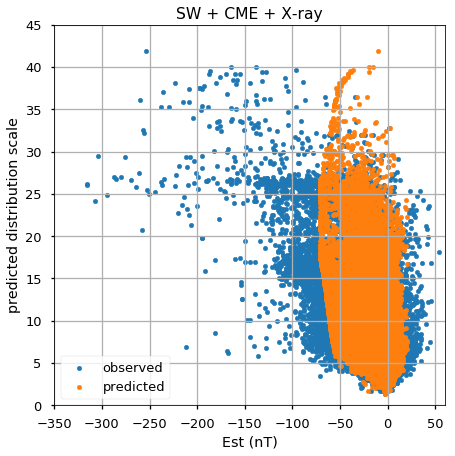

In [28]:
plt.figure(figsize=[7, 7])
plt.scatter(data_out_arr, data_out_pred_scale, marker='.', label='observed')
plt.scatter(data_out_pred_loc, data_out_pred_scale, marker='.', label='predicted')
plt.xlabel('Est (nT)')
plt.ylabel('predicted distribution scale')
plt.title('SW + CME + X-ray')
plt.legend()
plt.xlim([-350, 60])
plt.ylim([0, 45])
plt.grid(True)
plt.savefig('figures/est_forecasting_scale_vs_value_SWCMEXray.png', format='png', dpi=300)
plt.show()

In [ ]:
# compute reliability curves
thres = [-25, -50, -75, -100]
nthres = len(thres)
bin_edges = np.linspace(0, 1, 15)
bins = np.diff(bin_edges)/2 + bin_edges[0:-1]
nbins = len(bins)
first = False
exc = 'leq'

obs_exc = np.zeros((nbins, nthres))
for ii in range(nthres):
    obs_exc[:, ii] = reliability(data_out_pred, data_out_arr, 
                                 thres[ii], 
                                 bin_edges, 
                                 exc=exc, 
                                 first=first)

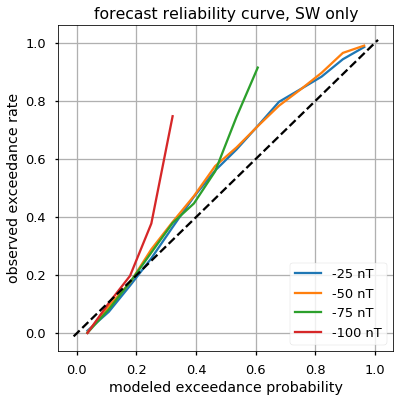

In [102]:
plt.figure(figsize=[6, 6])
for ii in range(nthres):
    plt.plot(bins, obs_exc[:,ii], label=str(thres[ii])+' nT')
abline(1, 0)
plt.xlabel('modeled exceedance probability')
plt.ylabel('observed exceedance rate')
plt.title('forecast reliability curve, SW only')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig('figures/est_forecast_reliability_SW.pdf', format='pdf')
plt.show()